In [1]:
! python -m pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 1.7 MB/s eta 0:00:0000:01
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [3]:
from prophet import Prophet

In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [16]:
mat = np.empty((0, 5))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['country', 'model', 'mae', 'mape', 'rsq'])

# Belgium

## train/test split

In [10]:
belgium = pd.read_csv('univariate_df_Belgium.csv')
belgium['date'] = pd.to_datetime(belgium['date'])
belgium = belgium.drop('Unnamed: 0', axis=1)
belgium = belgium.rename(columns={'date': 'ds', 'new_deaths': 'y'})
train_size = int(len(belgium) * 0.7)
belgium_train, belgium_test = belgium[0:train_size], belgium[train_size:]
print(belgium_train.shape, belgium_test.shape)

(141, 2) (61, 2)


## Baseline Prophet

In [12]:
model_baseline = Prophet()
model_baseline.fit(belgium_train)

12:45:06 - cmdstanpy - INFO - Chain [1] start processing
12:45:07 - cmdstanpy - INFO - Chain [1] done processing


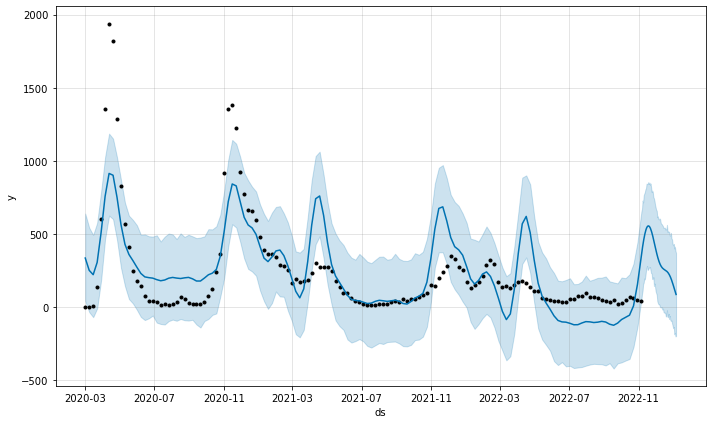

In [13]:
future_baseline = model_baseline.make_future_dataframe(periods=61)
forecast_baseline = model_baseline.predict(future_baseline)
model_baseline.plot(forecast_baseline); 

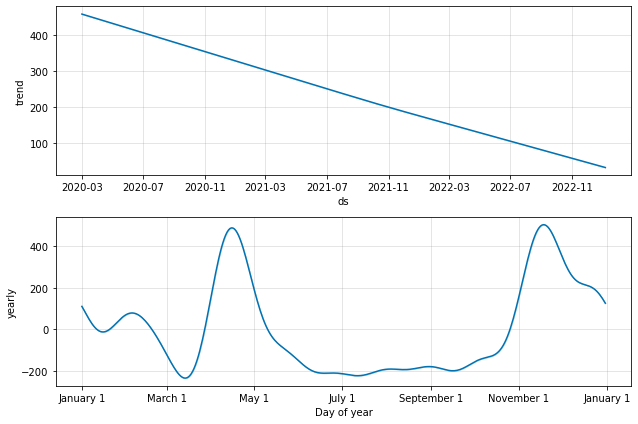

In [14]:
model_baseline.plot_components(forecast_baseline);

In [17]:
performance_baseline = pd.merge(belgium_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-61:], on='ds')
mae = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
mape = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
r2 = r2_score(performance_baseline['y'], performance_baseline['yhat'])
new_row = {'country': 'Belgium', 'model': 'Basseline Prophet', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

In [18]:
metrics

,country,model,mae,mape,rsq
0,Belgium,Basseline Prophet,296.499772,8.76159,-162.84532
